## Setup

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3,ResNet152V2, Xception, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

## Read the processed data into the training dataset and validation dataset
The data in this directory has been previously cleaned, which finally obtained a dataset of 500 images in each class which is divided into 3 directories in the training directory as much as 80% or 400 images in each class, the Validation data as much as 10% or 100 images in each class, and the test data as much as 10% or 100 images in each class.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Specify the path to the ZIP file
zip_file_path = '/content/drive/MyDrive/Capstone Project Huze/Dataset_fix.zip'

# Specify the directory where you want to extract the contents of the ZIP file
extract_dir = '/content'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optional: List the extracted files
# extracted_files = zip_ref.namelist()
# print("Extracted files:")
# for file in extracted_files:
#     print(file)


In [4]:
TRAINING_DIR = "/content/Dataset_fix/train_dir"
VALIDATION_DIR = "/content/Dataset_fix/validation_dir"
TEST_DIR = "/content/Dataset_fix/test_dir"

In [5]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=45,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        class_mode="categorical",
                                                        target_size=(299, 299))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  color_mode='rgb',
                                                                  class_mode="categorical",
                                                                  target_size=(299, 299))
    
    test_datagen = ImageDataGenerator(rescale=1./255.)
    
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      color_mode='rgb',
                                                      batch_size=32,
                                                      class_mode="categorical",
                                                      target_size=(299, 299))
    
    return train_generator, validation_generator, test_generator

In [6]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 8000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.


In [7]:
label_names = list(validation_generator.class_indices.keys())
print(f"{label_names} \nClass : {len(label_names)}")

['American_shorthair', 'Basset_hound', 'Beagle', 'Bengal', 'Boxer', 'British_Shorthair', 'Chihuahua', 'English_cocker_spaniel', 'Japanese_chin', 'Maine_Coon', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Samoyed', 'Scottish_fold', 'Siamese', 'Sphynx'] 
Class : 20


In [8]:
def plotImages(images_arr, folder_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, folder_name, ax in zip(images_arr, folder_names, axes):
        ax.imshow(img[:, :, 0])
        ax.axis('off')
        ax.set_title(folder_name)
    plt.tight_layout()
    plt.show()

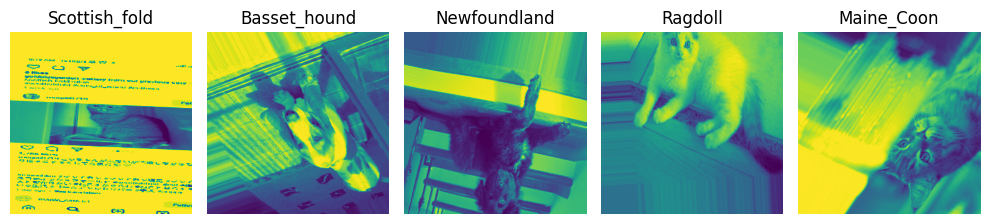

In [9]:
sample_training_images, labels = next(train_generator)
folder_names = [list(train_generator.class_indices.keys())[label.argmax()] for label in labels]

plotImages(sample_training_images[:5], folder_names)

## Creating a Callback class

In [10]:
callbacks = EarlyStopping(patience=10,
                          min_delta=0.001,
                          baseline=None,
                          mode='max',
                          monitor='val_accuracy',
                          restore_best_weights=True,
                          verbose=1
                         )

# Model

In [11]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(299, 299, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [13]:
# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/15
250/250 [==============================] - 245s 921ms/step - loss: 2.9437 - accuracy: 0.0716 - val_loss: 2.9320 - val_accuracy: 0.0900
Epoch 2/15
250/250 [==============================] - 232s 929ms/step - loss: 2.8089 - accuracy: 0.1277 - val_loss: 2.7250 - val_accuracy: 0.1550
Epoch 3/15
250/250 [==============================] - 231s 923ms/step - loss: 2.6995 - accuracy: 0.1604 - val_loss: 2.5623 - val_accuracy: 0.1720
Epoch 4/15
250/250 [==============================] - 229s 917ms/step - loss: 2.6297 - accuracy: 0.1754 - val_loss: 2.4791 - val_accuracy: 0.2040
Epoch 5/15
250/250 [==============================] - 229s 915ms/step - loss: 2.5808 - accuracy: 0.1889 - val_loss: 2.4962 - val_accuracy: 0.2230
Epoch 6/15
250/250 [==============================] - 231s 923ms/step - loss: 2.5262 - accuracy: 0.2100 - val_loss: 2.3463 - val_accuracy: 0.2560
Epoch 7/15
250/250 [==============================] - 233s 931ms/step - loss: 2.4858 - accuracy: 0.2185 - val_loss: 2.3837 -

### Training History

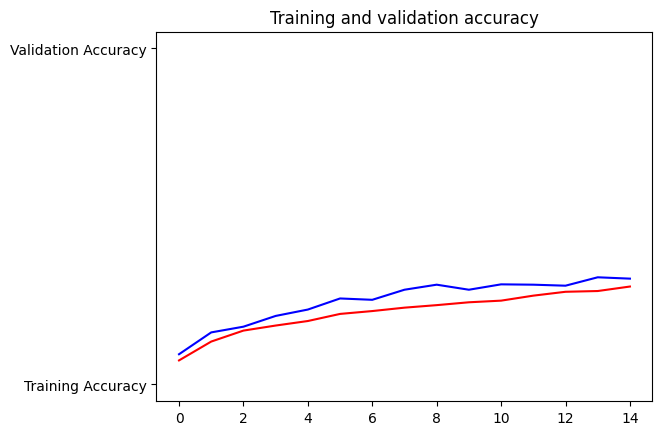

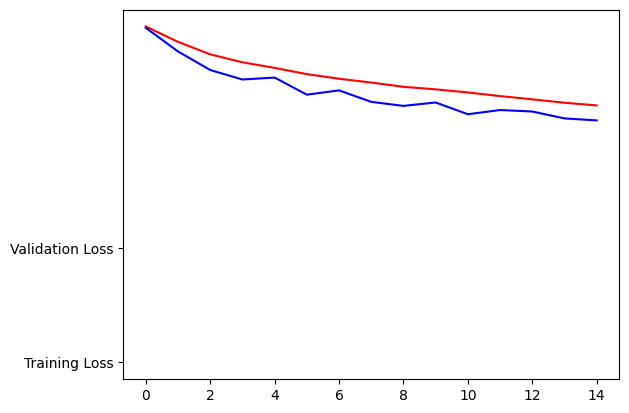

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Evaluate the Model

In [15]:
# Evaluate the model on the test images.
results = model.evaluate(test_generator)

for metric, value in zip(model.metrics_names, results):
    print(metric + ': {:.3}'.format(value))

32/32 [==============================] - 11s 346ms/step - loss: 2.1661 - accuracy: 0.3190
loss: 2.17
accuracy: 0.319


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
predictions = model.predict(test_generator)
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

# Assuming 'true_labels' is an array of true labels for the test data
true_labels = test_generator.classes

# Convert the predicted probabilities into class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

32/32 [==============================] - 10s 326ms/step - loss: 2.1661 - accuracy: 0.3190


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

predicted_labels = predictions.argmax(axis=1)
# Assuming 'true_labels' is an array of true labels for the test data
true_labels = test_generator.classes

# Convert the predicted probabilities into class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


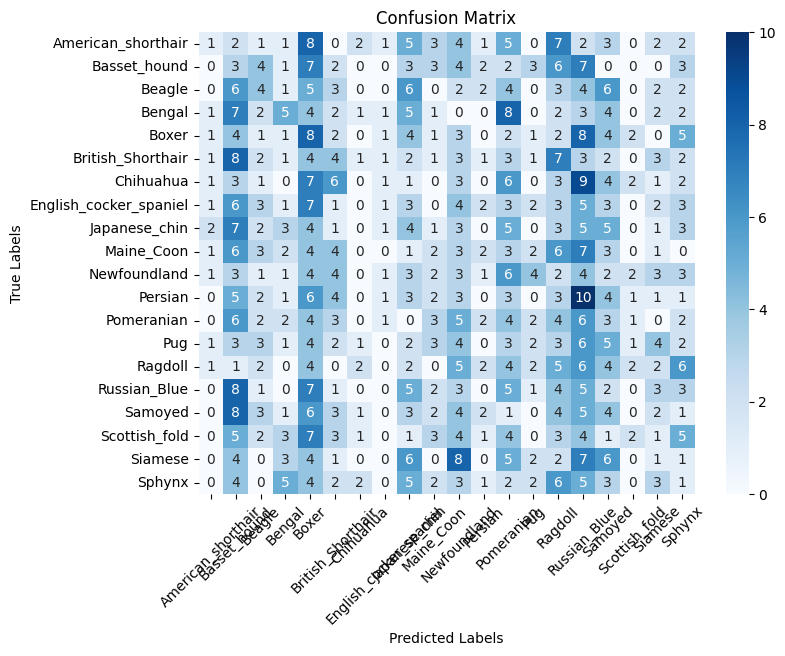

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the class labels for the confusion matrix
class_labels = test_generator.class_indices

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=0)

# Show the plot
plt.show()


### Testing models with images that have never been used

In [21]:
def load_and_prep_image(filename, img_shape=299):
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # our model is trained on images with 3 colour channels 
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img
     

In [22]:
def pred_and_plot(model, filename, label_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    indeks_kolom = tf.where(tf.round(pred)[0] == 1)
    pred_class = label_names[int(indeks_kolom)]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

## save model format Keras HDF5

In [23]:
model.save('CNNonly.h5')

## Save model Exporting to TFLite

In [24]:
export_dir = 'saved_model/CNNonly'

tf.saved_model.save(model, export_dir)

In [25]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [28]:
tflite_model_file = pathlib.Path('./CNNonly.tflite')
tflite_model_file.write_bytes(tflite_model)

17119336